In [ ]:
from typing import List, Optional

import cv2
import numpy as np
import time

from video_processing import gather_videos, ensure_fps, resize_to_width
from trajectory_analysis import compute_flow_farneback, block_weighted_average
from visualization import plot_quiver_colored, plot_streamplot_colored
from detectors import YOLOVehicleMaskDetector

def process_videos(videos: List[str],
                   grid: int = 16,
                   min_mag_px_per_frame: float = 0.5,
                   frame_step: int = 1,
                   resize_width: Optional[int] = 960,
                   fps_fallback: float = 30.0):
    """
    Aggregate optical flow from multiple videos into one vector field.
    Shows progress and timing.
    Returns: u, v, weights, mean_speed_px_s, Hc, Wc
    """
    if not videos:
        raise ValueError("No videos provided.")
    
    det = YOLOVehicleMaskDetector(
        model_path=r"models/visdrone/best.pt",
        classes=("car","van","truck","bus","motor"),
        imgsz=1536, max_det=1000, device=None,   # set to '0' if you have CUDA
        use_seg="auto",                          # try instance masks, else bbox
        dilation_px=3,                           # optional: expand a bit
        min_area_frac=0.00005                    # optional: drop tiny specks
    )

    sum_v_cells = None
    sum_w_cells = None
    Hc = Wc = None

    for idx, path in enumerate(videos, 1):
        print(f"\n[INFO] Processing video {idx}/{len(videos)}: {path}")
        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            print(f"[WARN] Could not open {path}, skipping.")
            continue

        fps = ensure_fps(cap, fps_fallback)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        processed_frames = 0
        start_video = time.time()

        ok, frame = cap.read()
        if not ok:
            print(f"[WARN] Empty video {path}, skipping.")
            cap.release(); continue

        frame = resize_to_width(frame, resize_width)
        prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if sum_v_cells is None:
            H, W = prev_gray.shape
            HH, WW = (H//grid)*grid, (W//grid)*grid
            Hc, Wc = HH//grid, WW//grid
            sum_v_cells = np.zeros((Hc, Wc, 2), dtype=np.float64)
            sum_w_cells = np.zeros((Hc, Wc), dtype=np.float64)

        while True:
            # Skip frames if needed
            for _ in range(frame_step):
                ok, frame = cap.read()
                if not ok: break
            if not ok: break

            cars_only = det.car_mask(frame, conf=0.65, iou=0.7)

            frame = resize_to_width(frame, resize_width)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            cars_only = cv2.resize(cars_only.astype(np.uint8),
                    (frame.shape[1], frame.shape[0]),
                    interpolation=cv2.INTER_NEAREST).astype(bool)

            flow = compute_flow_farneback(prev_gray, gray).astype(np.float32)
            vel  = flow * fps

            mag_pf = np.sqrt((flow**2).sum(axis=2))
            motion_mask = mag_pf >= float(min_mag_px_per_frame)

            mask = motion_mask & cars_only

            vw_sum, w_sum = block_weighted_average(vel, mask, grid)
            sum_v_cells += vw_sum
            sum_w_cells += w_sum


            prev_gray = gray
            processed_frames += 1

            # Show progress each 50 frames
            if processed_frames % 50 == 0 or processed_frames == total_frames:
                cv2.imwrite(f"runs/detect/frame_{processed_frames:06d}.png", (cars_only.astype(np.uint8) * 255))
                elapsed = time.time() - start_video
                est_total = elapsed / processed_frames * total_frames
                print(f"  Frame {processed_frames}/{total_frames} "
                      f"({processed_frames/total_frames:.1%}) "
                      f"Elapsed: {elapsed:.1f}s, Est. total: {est_total:.1f}s")

        cap.release()
        print(f"[INFO] Finished video {idx} in {time.time() - start_video:.1f}s, processed {processed_frames} frames")

    if sum_w_cells is None:
        raise RuntimeError("No valid motion found.")

    field = sum_v_cells / np.maximum(sum_w_cells[..., None], 1e-6)
    return field[...,0], field[...,1], sum_w_cells, Hc, Wc

In [2]:
INPUT_DIR = "C:/Users/gorm2/Downloads/data"  

videos = gather_videos(input_dir=INPUT_DIR, ext=".mp4", recursive=True)
print(f"Found {len(videos)} videos")
assert videos, "No .avi videos found—check the path or set recursive=False if needed."

u, v, w, Hc, Wc = process_videos(
    videos,
    grid=32,                # cell size (px)
    min_mag_px_per_frame=0.5,
    frame_step=3,           # try 2 or 3 to speed up
    resize_width=960,       # normalize resolution; set None to keep native
    fps_fallback=30.0
)

Found 1 videos

[INFO] Processing video 1/1: C:\Users\gorm2\Downloads\data\769-shorted.mp4
  Frame 50/593 (8.4%) Elapsed: 67.5s, Est. total: 800.2s
  Frame 100/593 (16.9%) Elapsed: 126.1s, Est. total: 747.6s
  Frame 150/593 (25.3%) Elapsed: 186.1s, Est. total: 735.9s
[INFO] Finished video 1 in 253.6s, processed 197 frames


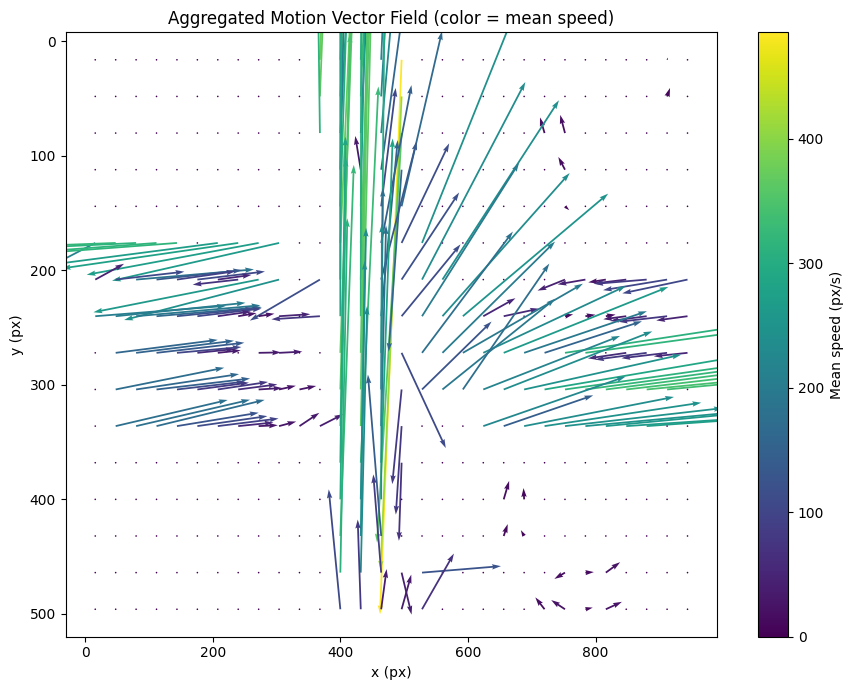

In [3]:
plot_quiver_colored(u,v,w, grid=32)

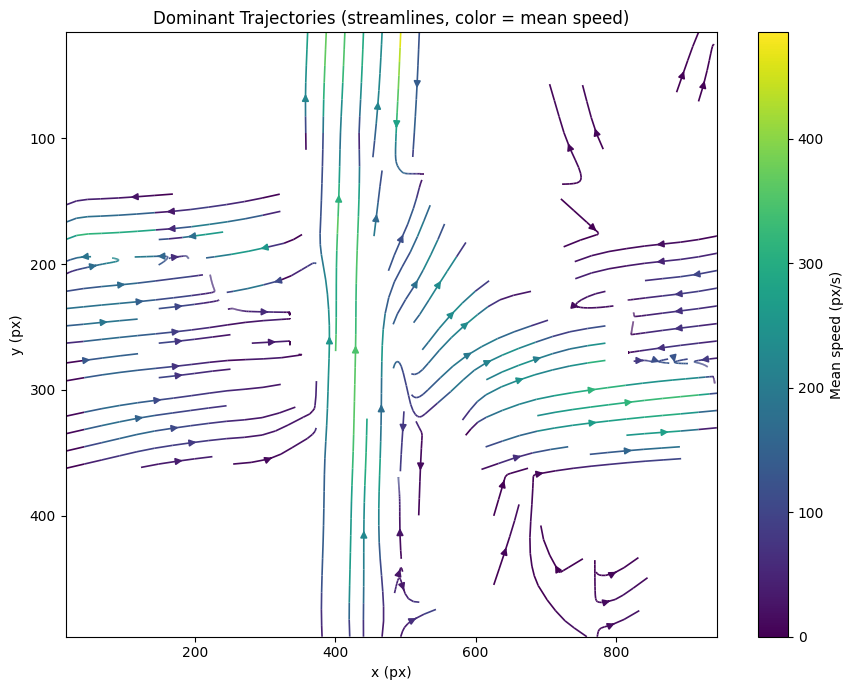

In [4]:
plot_streamplot_colored(u, v, grid=32)


Output #1 - 20/08/2025 -In 2223.6s, processed 8731 frames.  
PARAMS: frame-step=1, grid-size=16 pixels, min_mag_px_per_frame=0.5,  
For entries: [770.avi]  
COMMIT: Generating streamplot maps #e718ab5666b79471d8a51fec60fae78aa1d6aaba  
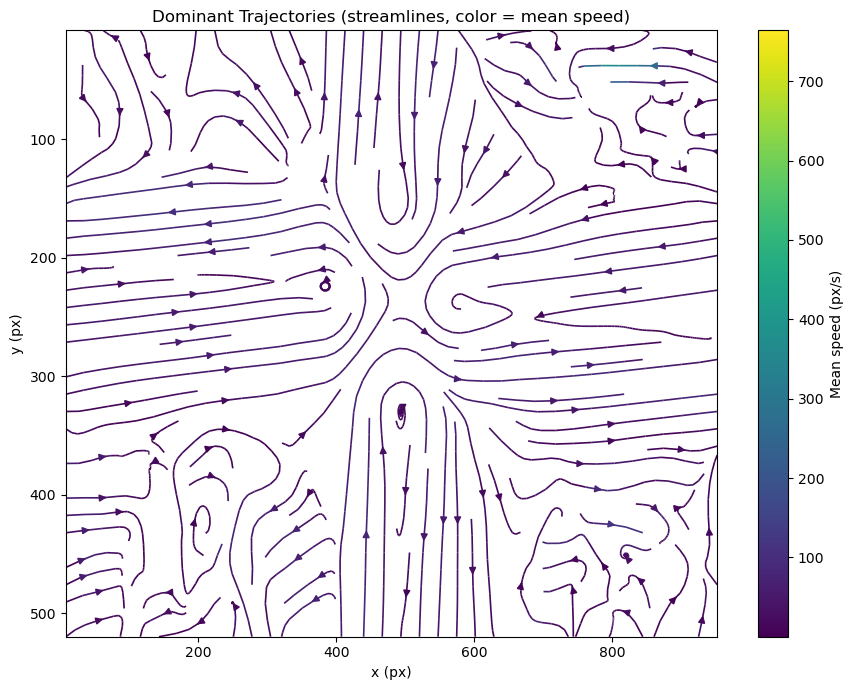



Output #2 - 20/08/2025 -In 592.2s, processed 2910 frames.  
PARAMS: frame-step=3, grid-size=32 pixels, min_mag_px_per_frame=0.5,  
For entries: [770.avi]  
COMMIT: Generating streamplot maps #e718ab5666b79471d8a51fec60fae78aa1d6aaba  
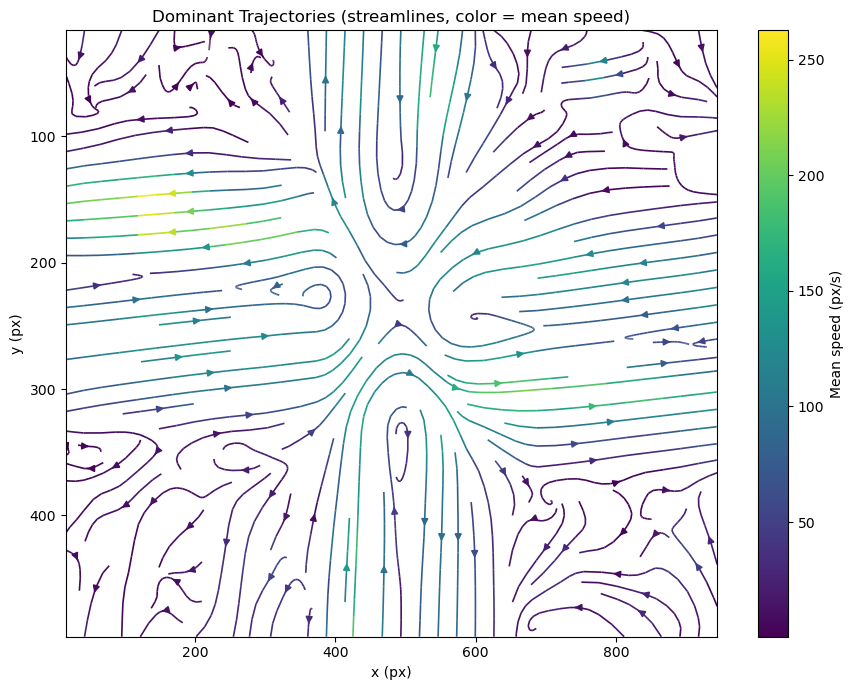

Output #3 - 23/08/2025 -In 1814.0s, processed 5821 frames.  
PARAMS: frame-step=3, grid-size=32 pixels, min_mag_px_per_frame=0.5,  
For entries: [769.avi, 770.avi]
COMMIT: Generating streamplot maps #e718ab5666b79471d8a51fec60fae78aa1d6aaba  
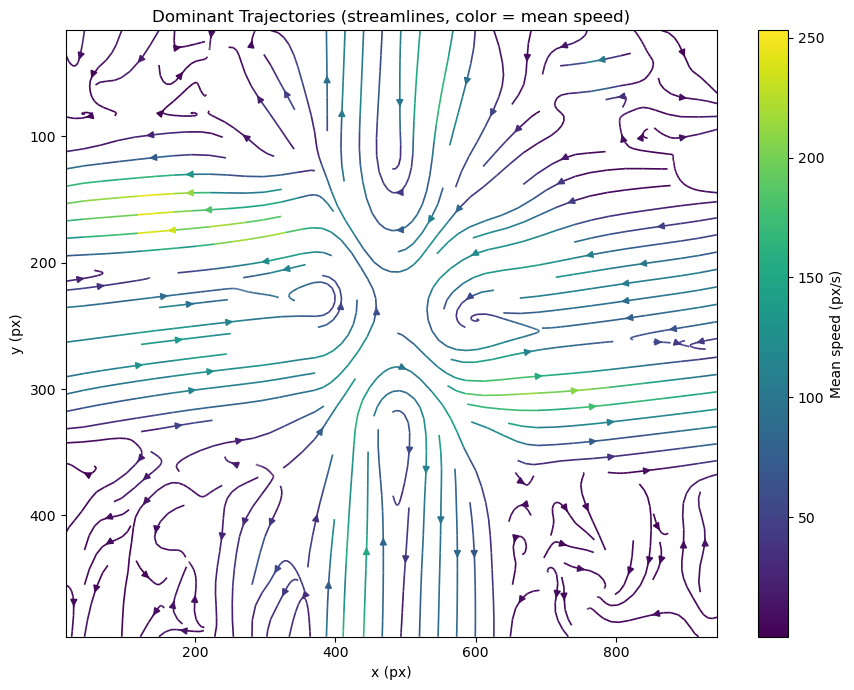